# Forest Cover Classification Using Linear SVC

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# Reading the dataset
data_set = pd.read_csv("covtype.csv")
data_set.shape

(581012, 55)

In [3]:
# Separating the input features and target variable
X = data_set.iloc[:, :-1]
y = data_set['Cover_Type']

In [4]:
# Checking for missing values
miss_val = X.isnull().sum().sum()
print(miss_val)

0


In [5]:
# Normalizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Splitting the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [7]:
X_train.shape

(464809, 54)

In [8]:
X_test.shape

(116203, 54)

In [10]:
# Defining the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

In [11]:
# Initializing the LinearSVC model
lsvc = LinearSVC(random_state=42)

# Initializing GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=lsvc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fitting GridSearchCV to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=LinearSVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300]},
             verbose=2)

In [12]:
# Best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'C': 100, 'max_iter': 100}


In [13]:
# Best estimator
best_lsvc = grid_search.best_estimator_

# Making predictions with the best estimator
y_train_pred = best_lsvc.predict(X_train)
y_test_pred = best_lsvc.predict(X_test)

In [16]:
# Computing the performance metrics for the training subset
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print("Training Accuracy (in %):",round(train_accuracy*100,3))
print("Training Precision (in %):",round(train_precision*100,3))
print("Training Recall (in %):",round(train_recall*100,3))
print("Training F1 Score (in %):",round(train_f1*100,3))

Training Accuracy (in %): 71.274
Training Precision (in %): 70.398
Training Recall (in %): 71.274
Training F1 Score (in %): 69.713


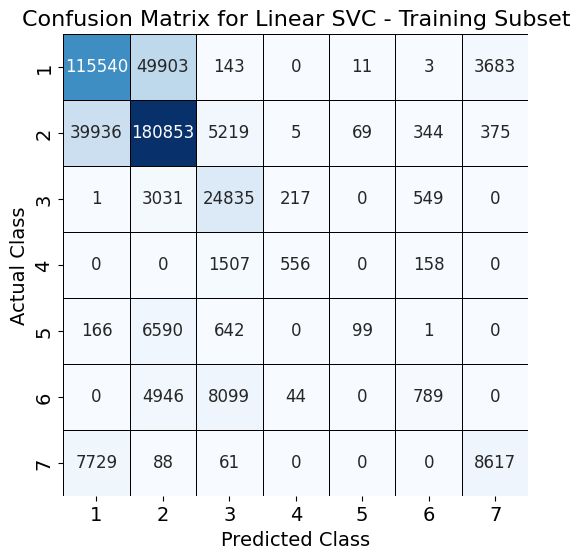

In [17]:
conf_mat_train = confusion_matrix(y_train,y_train_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_train, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=best_lsvc.classes_, yticklabels=best_lsvc.classes_, annot_kws={"size": 12})
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for Linear SVC - Training Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

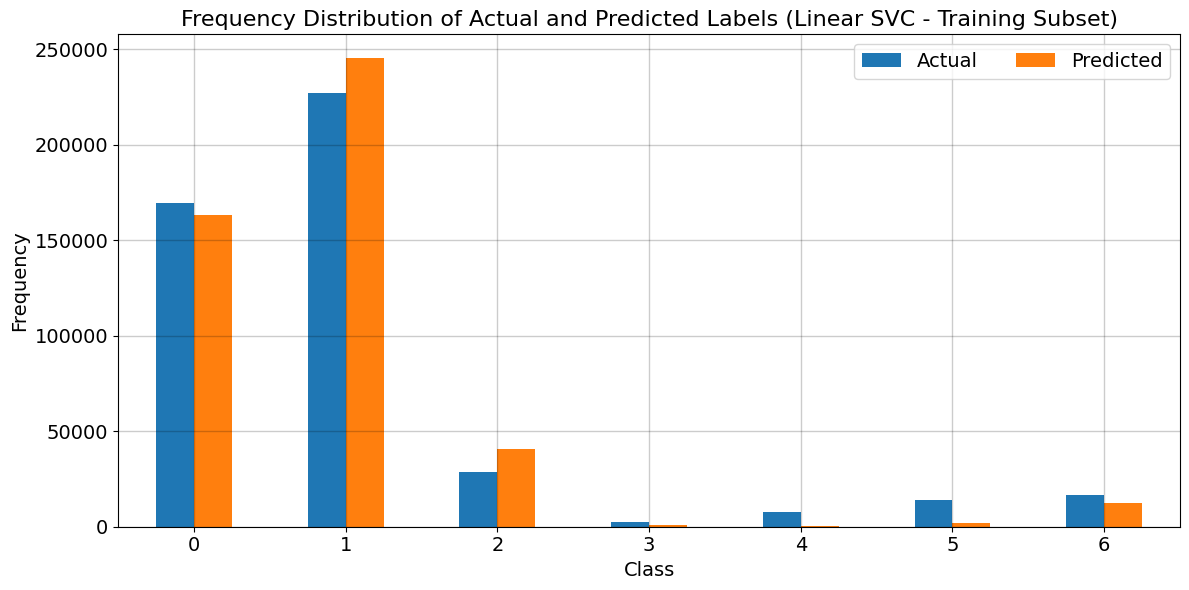

In [18]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_train, actual_counts_train = np.unique(y_train, return_counts=True)
predicted_labels_train, predicted_counts_train = np.unique(y_train_pred, return_counts=True)

labels_train = np.unique(y_train)

x_train = np.arange(len(labels_train))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_train = ax.bar(x_train - width/2, actual_counts_train, width, label='Actual')
rects2_train = ax.bar(x_train + width/2, predicted_counts_train, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (Linear SVC - Training Subset)', color='black', fontsize=16)
ax.set_xticks(x_train)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_train) - 0.5]) 
fig.tight_layout()
plt.show()

In [20]:
# Computing the performance metrics for the test subset
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Test Accuracy (in %):",round(test_accuracy*100,3))
print("Test Precision (in %):",round(test_precision*100,3))
print("Test Recall (in %):",round(test_recall*100,3))
print("Test F1 Score (in %):",round(test_f1*100,3))

Test Accuracy (in %): 71.272
Test Precision (in %): 70.354
Test Recall (in %): 71.272
Test F1 Score (in %): 69.663


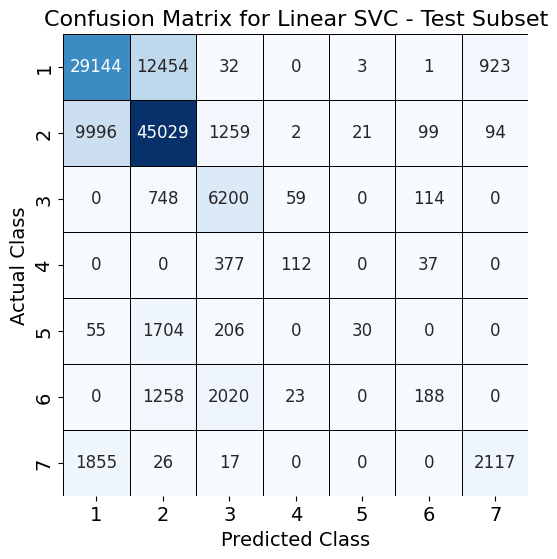

In [22]:
conf_mat_test = confusion_matrix(y_test,y_test_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=best_lsvc.classes_, yticklabels=best_lsvc.classes_, annot_kws={"size": 12})
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for Linear SVC - Test Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

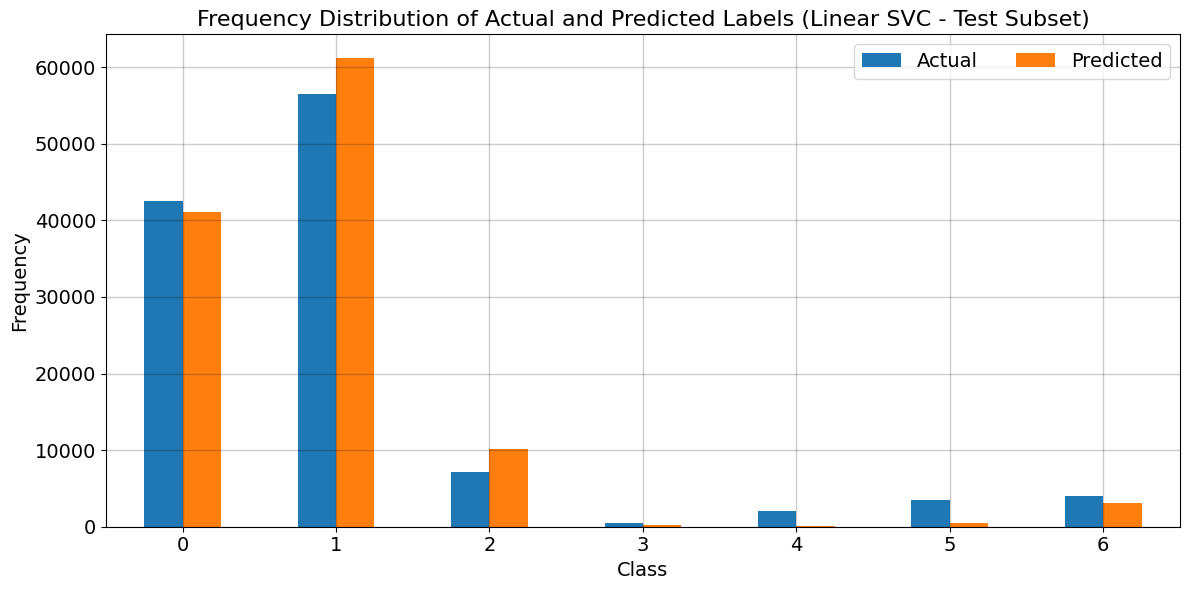

In [23]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_test, actual_counts_test = np.unique(y_test, return_counts=True)
predicted_labels_test2, predicted_counts_test2 = np.unique(y_test_pred, return_counts=True)

labels_test = np.unique(y_test)

x_test = np.arange(len(labels_test))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_test = ax.bar(x_test - width/2, actual_counts_test, width, label='Actual')
rects2_test = ax.bar(x_test + width/2, predicted_counts_test2, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (Linear SVC - Test Subset)', color='black', fontsize=16)
ax.set_xticks(x_test)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_test) - 0.5]) 
fig.tight_layout()
plt.show()

***